In [1]:
%matplotlib inline
import numpy as np
import scipy 
import matplotlib.pyplot as plt


Flow through fixed particle bed 
==========================================================

The liquid passing through a fixed particle bed is simulated. 

In the particle bed, the pressure drop rate can be estimated by using the Ergun's equation:

$$
\frac{\Delta p}{\Delta y} = 150 \frac{(1-\epsilon)^2 \mu U}{\epsilon^3 d_p^2} + 1.75 \frac{(1-\epsilon) \rho_f U^2}{d_p}
$$

Test definition
==========================================================



In [2]:
# general properties
g = 9.81 # [m/s²] in positive x direction

# particle properties
d_p = 0.00395 # [m]
rho_s = 2500.0 # [kg/m³]
A_p = np.pi * d_p ** 2.0 / 4.0 # [m²]
V_p = 4.0 / 3.0 * np.pi * (d_p / 2.0) ** 3.0 # [m³]

#domain properties
W = 0.1 # [m] cross-section
l = 0.8 # [m] length
yinit = 0.15 # [m] init of particles bed
yfinal = 0.65 # [m] final of particles bed

number_particles = 92572
#number_particles = 90887
particles_volume = number_particles*V_p
bed_volume = W*W*(yfinal-yinit)
estimated_void_fraction = 1 - (particles_volume/bed_volume)
#estimated_void_fraction = 0.403
print(estimated_void_fraction)


# fluid properties
rho_f = 1000 # [kg/m³]
mu_f = 0.001 # [Pa s]
regime = 1
superficial_velocity = 0.1 #[m/s] superficial velocity at inlet


volume = W*W*(yfinal-yinit)
total_particle_volume = volume*(1-estimated_void_fraction)
total_particle_number = total_particle_volume/V_p
print(total_particle_number)

total_mass = total_particle_number * rho_s * V_p # [kg]
#print(mass)

#injection properties
len_inj = 0.1 # [m]
wid_inj = 0.1 # [m]
time_inj = 1.0 # [s]
mass_flow_inj = total_mass/time_inj # [kg/s]
mass_flow_ton = mass_flow_inj*60*60/1000 #[ton/h]
print(mass_flow_ton, "t/h")



0.4025527705197902
92572.0
26.885125326609447 t/h


In [3]:
# helper functions

def pressure_drop_Ergun(void_fraction, mu_f, sup_vel, d, rho_f):
    A = 150 * (1 - void_fraction) * (1 - void_fraction) * mu_f * sup_vel / (void_fraction*void_fraction*void_fraction*d*d)
    B = 1.75 * (1 - void_fraction) * rho_f * sup_vel * sup_vel / (void_fraction*void_fraction*void_fraction*d)
    
    return A + B


print(pressure_drop_Ergun(estimated_void_fraction, mu_f, superficial_velocity, d_p, rho_f))
print(pressure_drop_Ergun(0.41, mu_f, superficial_velocity, d_p, rho_f))

def estimated_porosity(y, y1, y2, porosity):
    if y<=y1 or y>=y2:
        void_fraction = 1.0
    else:
        void_fraction = porosity
    return void_fraction


print(estimated_porosity(0.39, yinit, yfinal, estimated_void_fraction))


45836.77111200563
42782.05420727426
0.4025527705197902


Results
==========================================================

250


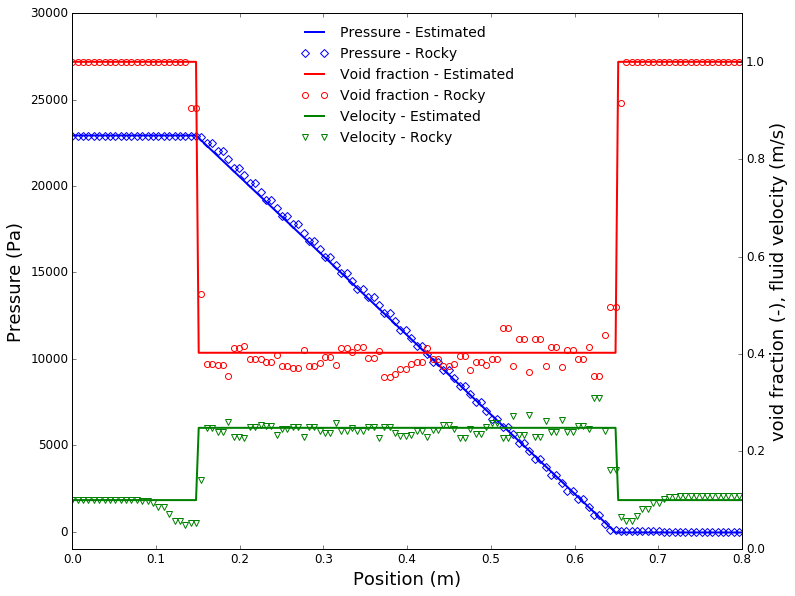

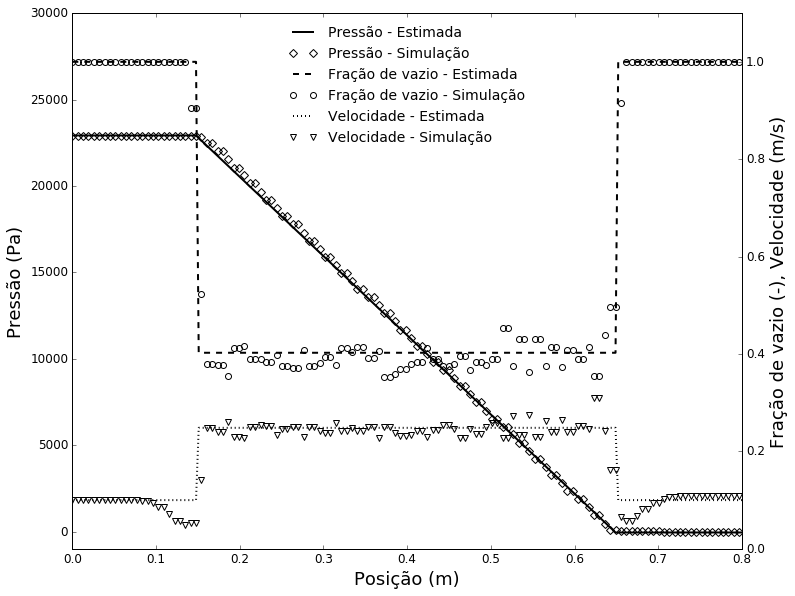

In [5]:

initial_pressure = (yfinal-yinit)*pressure_drop_Ergun(estimated_void_fraction, mu_f, superficial_velocity, d_p, rho_f)


# loading the digitized data
pressure_two_way = open("results_no_gravity_rocky4.csv", 'r')
position_rocky, pressure_rocky, void_rocky, velocityY = np.loadtxt(pressure_two_way, delimiter = ';', skiprows = 1, unpack = True)    
pressure_two_way.close()

print(len(position_rocky))

steps = len(position_rocky)

void_fraction_array = np.zeros(steps)
pressure_array = np.zeros(steps)
real_velocity_array = np.zeros(steps)
y = np.linspace(0, 0.8, steps)

# calculating the values using Ergun
for index in range(len(y)):
    void_fraction_array[index] = estimated_porosity(y[index], yinit, yfinal,  estimated_void_fraction)
    #void_fraction_array[index] = void_rocky[index]
    pressure_array[index] = pressure_array[index-1]-(y[index]-y[index-1])*pressure_drop_Ergun(void_fraction_array[index], mu_f, superficial_velocity, d_p, rho_f)
    real_velocity_array[index] = superficial_velocity/void_fraction_array[index]
    

distance = position_rocky[-1]-position_rocky


    
# plotting
label_size = 12
plt.rcParams["figure.figsize"] = (12.0, 9.6)
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size 
fig = plt.figure()
ax1 = fig.add_subplot(111)
s1 = ax1.plot(y,initial_pressure + pressure_array, linewidth = 2, color = "blue", label = "Pressure - Estimated")
r1 = ax1.plot(position_rocky,pressure_rocky, linestyle = "None", marker = 'D', markeredgecolor = "blue",  markeredgewidth = 1.0, markevery=2, 
           markerfacecolor = "none", label = "Pressure - Rocky")
#r1 = ax1.plot(position_rocky,real_pressure, linestyle = "None", marker = 'D', markeredgecolor = "blue",  markeredgewidth = 1.0, markevery=3, 
#           markerfacecolor = "none", label = "Pressure - Rocky")
ax1.set_xlabel('Position (m)',  fontsize = 18)
ax1.set_xlim([0, 0.8])
ax1.set_ylim([-1000, 30000])
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Pressure (Pa)',  fontsize = 18, color='black')

ax2 = ax1.twinx()
s2 = ax2.plot(y,void_fraction_array, linewidth = 2, color = "red", label = "Void fraction - Estimated")
s3 = ax2.plot(y,real_velocity_array, linewidth = 2, color = "green", label = "Velocity - Estimated")
r2 = ax2.plot(position_rocky,void_rocky, linestyle = "None", color = "red", marker = 'o', markeredgecolor = "red",  markeredgewidth = 1.0, markevery=2, 
           markerfacecolor = "none", label = "Void fraction - Rocky")
r3 = ax2.plot(position_rocky,velocityY, linestyle = "None", color = "green", marker = 'v', markeredgecolor = "green",  markeredgewidth = 1.0, markevery=2, 
           markerfacecolor = "none", label = "Velocity - Rocky")
ax2.set_ylabel('void fraction (-), fluid velocity (m/s)', color='black',fontsize = 18)
ax2.set_xlim([0, 0.8])
ax2.set_ylim([0, 1.1])
plt.xticks(fontsize = 200) 
    
lns = s1+r1+s2+r2+s3+r3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper center', frameon = False, fontsize = 14)
plt.savefig('fixedBedResultsenglish.png')  
plt.show()

# plotting

fig2 = plt.figure()
ax1 = fig2.add_subplot(111)
s1 = ax1.plot(y,initial_pressure + pressure_array, linewidth = 2, linestyle= '-', color = "black", label = "Pressão - Estimada")
r1 = ax1.plot(position_rocky,pressure_rocky, linestyle = "None", marker = 'D', markeredgecolor = "black",  markeredgewidth = 1.0, markevery=2, 
           markerfacecolor = "none", label = "Pressão - Simulação")
ax1.set_xlabel('Posição (m)',  fontsize = 18)
ax1.set_xlim([0, 0.8])
ax1.set_ylim([-1000, 30000])
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Pressão (Pa)',  fontsize = 18, color='black')

ax2 = ax1.twinx()
s2 = ax2.plot(y,void_fraction_array, linewidth = 2, color = "black", linestyle= '--', label = "Fração de vazio - Estimada")
s3 = ax2.plot(y,real_velocity_array, linewidth = 2, color = "black", linestyle= ':', label = "Velocidade - Estimada")
r2 = ax2.plot(position_rocky,void_rocky, linestyle = "None", color = "black", marker = 'o', markeredgecolor = "black",  markeredgewidth = 1.0, markevery=2, 
           markerfacecolor = "none", label = "Fração de vazio - Simulação")
r3 = ax2.plot(position_rocky,velocityY, linestyle= 'None', color = "black", marker = 'v', markeredgecolor = "black",  markeredgewidth = 1.0, markevery=2, 
           markerfacecolor = "none", label = "Velocidade - Simulação")
ax2.set_ylabel('Fração de vazio (-), Velocidade (m/s)', color='black',fontsize = 18)
ax2.set_xlim([0, 0.8])
ax2.set_ylim([0, 1.1])
plt.xticks(fontsize = 200) 
    
lns = s1+r1+s2+r2+s3+r3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper center', frameon = False, fontsize = 14)
plt.savefig('fixedBedResults.png')  
plt.show()



45836.77111200563
46728.1898425
1.94476772433


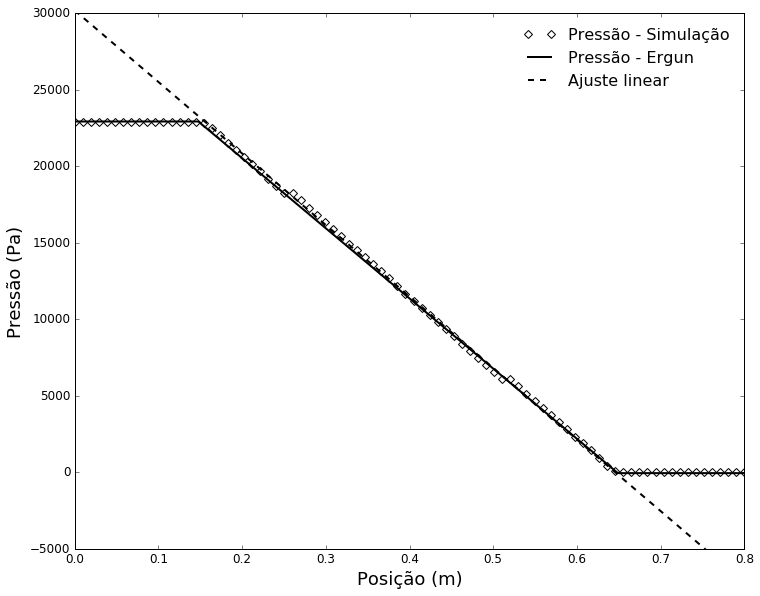

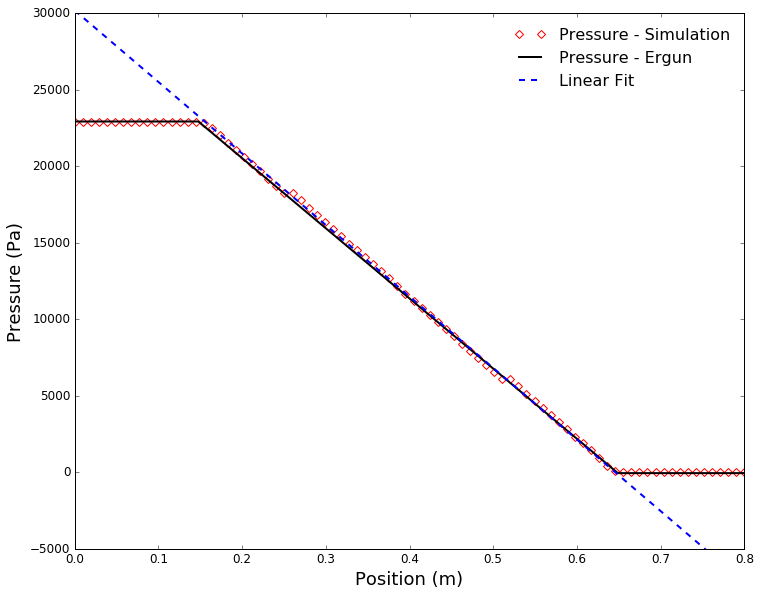

In [10]:
#limitando o leito a região com partículas
bed_void_cutted1 = void_rocky[np.argmax(void_rocky<0.8):]
bed_void_cutted2 = bed_void_cutted1[0:np.argmax(bed_void_cutted1>0.8)]

bed_position_cutted1 = position_rocky[np.argmax(void_rocky<0.8):]
bed_position_cutted2 = bed_position_cutted1[0:np.argmax(bed_void_cutted1>0.8)]

bed_pressure_cutted1 = pressure_rocky[np.argmax(void_rocky<0.8):]
bed_pressure_cutted2 = bed_pressure_cutted1[0:np.argmax(bed_void_cutted1>0.8)]

#fazendo o ajuste linear da pressao versus posicao
fit = np.polyfit(bed_position_cutted2,bed_pressure_cutted2,1)

#recuperando a regressao linear
fit_fn = np.poly1d(fit) 


#calculando o erro entre o previsto por Ergun e o previsto pela simulação
error = np.absolute(100*(pressure_drop_Ergun(estimated_void_fraction, mu_f, superficial_velocity, d_p, rho_f)- (-fit_fn[1]))/
pressure_drop_Ergun(estimated_void_fraction, mu_f, superficial_velocity, d_p, rho_f))
print(pressure_drop_Ergun(estimated_void_fraction, mu_f, superficial_velocity, d_p, rho_f))
print(-fit_fn[1])
print(error)

plt.plot(position_rocky, pressure_rocky, linestyle = "None", marker = 'D', markeredgecolor = "black",  markeredgewidth = 1.0, markevery=3, 
           markerfacecolor = "none", label = "Pressão - Simulação")
plt.plot(y,initial_pressure + pressure_array, linewidth = 2, linestyle= '-', color = "black", label = "Pressão - Ergun")
plt.plot(position_rocky,fit_fn(position_rocky), linewidth = 2, linestyle= '--', color = "black", label = "Ajuste linear")
plt.xlabel('Posição (m)',  fontsize = 18)
plt.ylabel('Pressão (Pa)',  fontsize = 18)
plt.xlim(xmax = 0.8, xmin = 0.0)
plt.ylim(ymax = 30000, ymin = -5000)
plt.legend(fontsize = 16, loc='upper right', frameon = False)
plt.savefig('caso3_linear_fit.png')  
plt.show()

plt.plot(position_rocky, pressure_rocky, linestyle = "None", marker = 'D', markeredgecolor = "red",  markeredgewidth = 1.0, markevery=3, 
           markerfacecolor = "none", label = "Pressure - Simulation")
plt.plot(y,initial_pressure + pressure_array, linewidth = 2, linestyle= '-', color = "black", label = "Pressure - Ergun")
plt.plot(position_rocky,fit_fn(position_rocky), linewidth = 2, linestyle= '--', color = "blue", label = "Linear Fit")
plt.xlabel('Position (m)',  fontsize = 18)
plt.ylabel('Pressure (Pa)',  fontsize = 18)
plt.xlim(xmax = 0.8, xmin = 0.0)
plt.ylim(ymax = 30000, ymin = -5000)
plt.legend(fontsize = 16, loc='upper right', frameon = False)
plt.savefig('caso3_linear_fit_english.png')  
plt.show()